# Data Exploration and Preprocessing

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

Load the FRED-MD dataset. The first row contains transformation codes.

In [30]:
# Load raw data
filepath = '/Users/liyangwang/Senior Project/Senior Thesis/data/macro_dataset.csv'
raw_data = pd.read_csv(filepath, index_col=0)

print(f"Raw data shape: {raw_data.shape}")
print(f"\nFirst few rows:")
raw_data.head()

Raw data shape: (803, 126)

First few rows:


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1/1/1959,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9998,23.6312,22.5507,32.1377,19.7514,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2/1/1959,2593.596,2434.8,15.346,278713.9773,17819.01912,22.4306,23.9501,22.7461,32.3734,19.8551,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3/1/1959,2610.396,2452.7,15.491,277775.2539,17967.91336,22.7538,24.0951,22.8577,32.3734,20.2439,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4/1/1959,2627.446,2470.0,15.435,283362.7075,17978.97983,23.2384,24.4431,23.1926,32.8841,20.3735,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


In [ ]:
tcodes = pd.read_csv(filepath, nrows=1, index_col=0)
tcodes.columns = [c.upper() for c in tcodes.columns]

print("Transformation codes distribution:")
print(tcodes.T.value_counts().sort_index())

Transformation codes distribution:
Transform:
1             11
2             19
4             10
5             52
6             33
7              1
Name: count, dtype: int64


In [ ]:
data = pd.read_csv(filepath, skiprows=[1], index_col=0)
data.columns = [c.upper() for c in data.columns]

# Clean index and set date range
data = data.loc[pd.notna(data.index), :]
data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))

print(f"Data shape after cleaning: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")

Data shape after cleaning: (802, 126)
Date range: 1959-01-01 00:00:00 to 2025-10-01 00:00:00


## 2. Transformation Codes

FRED-MD provides transformation codes to make each series stationary:
- 1: No transformation (already stationary)
- 2: First difference
- 3: Second difference
- 4: Log level
- 5: Log first difference (growth rate)
- 6: Log second difference (acceleration)
- 7: Percent change

In [33]:
def transform_series(x, tcode):
    """
    Apply FRED-MD transformation codes to a series.
    
    Parameters:
    -----------
    x : pd.Series
        Raw time series
    tcode : int
        Transformation code (1-7)
    
    Returns:
    --------
    pd.Series : Transformed series
    """
    if tcode == 1:
        return x
    elif tcode == 2:
        return x.diff()
    elif tcode == 3:
        return x.diff().diff()
    elif tcode == 4:
        return np.log(x)
    elif tcode == 5:
        return np.log(x).diff()
    elif tcode == 6:
        return np.log(x).diff().diff()
    elif tcode == 7:
        return x.pct_change()
    else:
        raise ValueError(f"Unknown tcode: {tcode}")

# Test on a single series
test_series = 'INDPRO'  # Industrial Production
test_tcode = int(tcodes[test_series].values[0])
print(f"{test_series} transformation code: {test_tcode}")
print(f"Original values (first 5): {data[test_series].head().values}")
print(f"Transformed values (first 5): {transform_series(data[test_series], test_tcode).head().values}")

INDPRO transformation code: 5
Original values (first 5): [21.9998 22.4306 22.7538 23.2384 23.5885]
Transformed values (first 5): [       nan 0.01939274 0.01430607 0.02107392 0.01495322]


In [34]:
# Apply transformations to all series
data_transformed = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))

print(f"Transformed data shape: {data_transformed.shape}")
print(f"\nMissing values per column (first 10):")
print(data_transformed.isna().sum().head(10))

Transformed data shape: (802, 126)

Missing values per column (first 10):
RPI                3
W875RX1            3
DPCERA3M086SBEA    3
CMRMTSPLX          4
RETAILX            2
INDPRO             3
IPFPNSS            3
IPFINAL            3
IPCONGD            3
IPDCONGD           3
dtype: int64


## 3. Missing Value Handling

Some series start later or have missing values due to differencing.

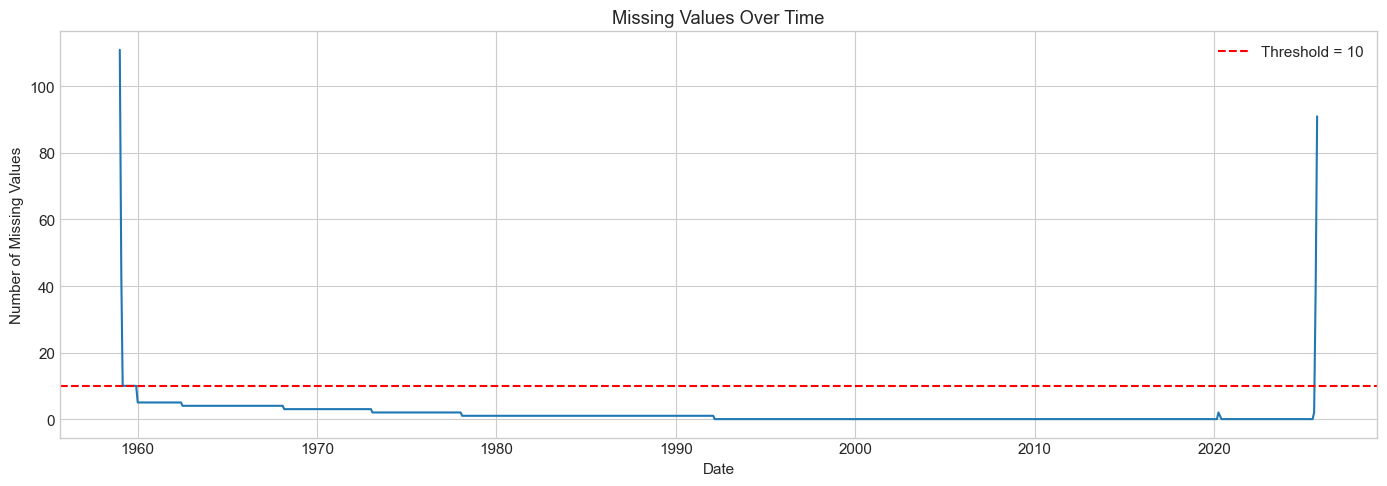


First date with < 5 missing values: 1962-07-01 00:00:00


In [35]:
# Check missing values pattern
missing_by_date = data_transformed.isna().sum(axis=1)

plt.figure(figsize=(14, 5))
plt.plot(missing_by_date.index, missing_by_date.values)
plt.xlabel('Date')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values Over Time')
plt.axhline(y=10, color='r', linestyle='--', label='Threshold = 10')
plt.legend()
plt.tight_layout()
plt.show()

# Find date where most series have complete data
good_dates = missing_by_date[missing_by_date < 5].index
print(f"\nFirst date with < 5 missing values: {good_dates[0]}")

In [36]:

start_date = "1962-07-01"  # Start from July 1962
data_clean = data_transformed.dropna(axis=1, subset=[pd.Timestamp(start_date)])

data_clean = data_clean.fillna(method='ffill').dropna()

data_clean = data_clean[data_clean.index >= start_date]

print(f"Clean data shape: {data_clean.shape}")
print(f"Date range: {data_clean.index[0]} to {data_clean.index[-1]}")
print(f"Total months: {len(data_clean)}")
print(f"\nRemaining missing values: {data_clean.isna().sum().sum()}")

Clean data shape: (760, 122)
Date range: 1962-07-01 00:00:00 to 2025-10-01 00:00:00
Total months: 760

Remaining missing values: 0


## 4. Standardization

Standardize each series to zero mean and unit variance so all features contribute equally.

In [37]:
# Standardize
scaler = StandardScaler()
data_standardized = pd.DataFrame(
    scaler.fit_transform(data_clean),
    index=data_clean.index,
    columns=data_clean.columns
)

print("Standardized data summary:")
print(f"Mean (should be ~0): {data_standardized.mean().mean():.6f}")
print(f"Std (should be ~1): {data_standardized.std().mean():.6f}")

# Quick check
print(f"\nSample of standardized data:")
data_standardized.head()

Standardized data summary:
Mean (should be ~0): 0.000000
Std (should be ~1): 1.000659

Sample of standardized data:


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLX,RETAILX,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSX
1962-07-01,0.190332,0.382186,0.074047,-0.648921,0.696730,0.817033,0.825300,1.043552,1.500706,0.605726,...,-0.725116,-0.208612,-0.514893,1.082759,0.871106,1.949090,-0.192078,-0.102867,-0.416127,0.039132
1962-08-01,-0.080265,-0.202574,0.021537,1.759356,0.090380,-0.081436,-0.175951,-0.364563,-1.237633,-0.486692,...,-0.189426,0.921956,-0.059023,-0.006822,-1.310432,-0.008473,-0.027190,0.011025,-0.299954,-0.497671
1962-09-01,-0.175851,-0.191146,1.067028,-1.528882,-0.114371,0.474607,0.486564,0.235619,0.485377,0.339293,...,0.225057,1.405331,-0.115593,-1.082811,0.434224,-0.976522,-0.697402,-0.418921,0.247259,-0.139462
1962-10-01,0.227106,0.150943,-0.954141,1.483340,0.688135,-0.082255,-0.506689,-0.064628,-0.326125,0.073761,...,-1.687266,-2.253100,0.281417,-0.002291,-0.433587,0.963907,0.425151,0.134451,1.304363,0.948028
1962-11-01,0.093463,0.385854,1.331551,0.722374,0.027219,0.249147,0.484492,0.233890,0.482825,-0.024658,...,1.537831,0.378226,0.223842,1.073736,0.863674,-0.972266,0.175581,0.200386,-1.670646,-0.359594


In [38]:

X = data_standardized.values
dates = data_standardized.index
feature_names = data_standardized.columns.tolist()
T, p = X.shape

print(f"\nFinal data matrix: {T} observations x {p} features")


Final data matrix: 760 observations x 122 features


## 5. Exploratory Data Analysis

In [39]:
# Select key economic indicators for visualization
key_indicators = ['INDPRO', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'S&P 500', 'M2SL']
key_indicators = [k for k in key_indicators if k in feature_names]

print(f"Key indicators found: {key_indicators}")

Key indicators found: ['INDPRO', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'S&P 500', 'M2SL']


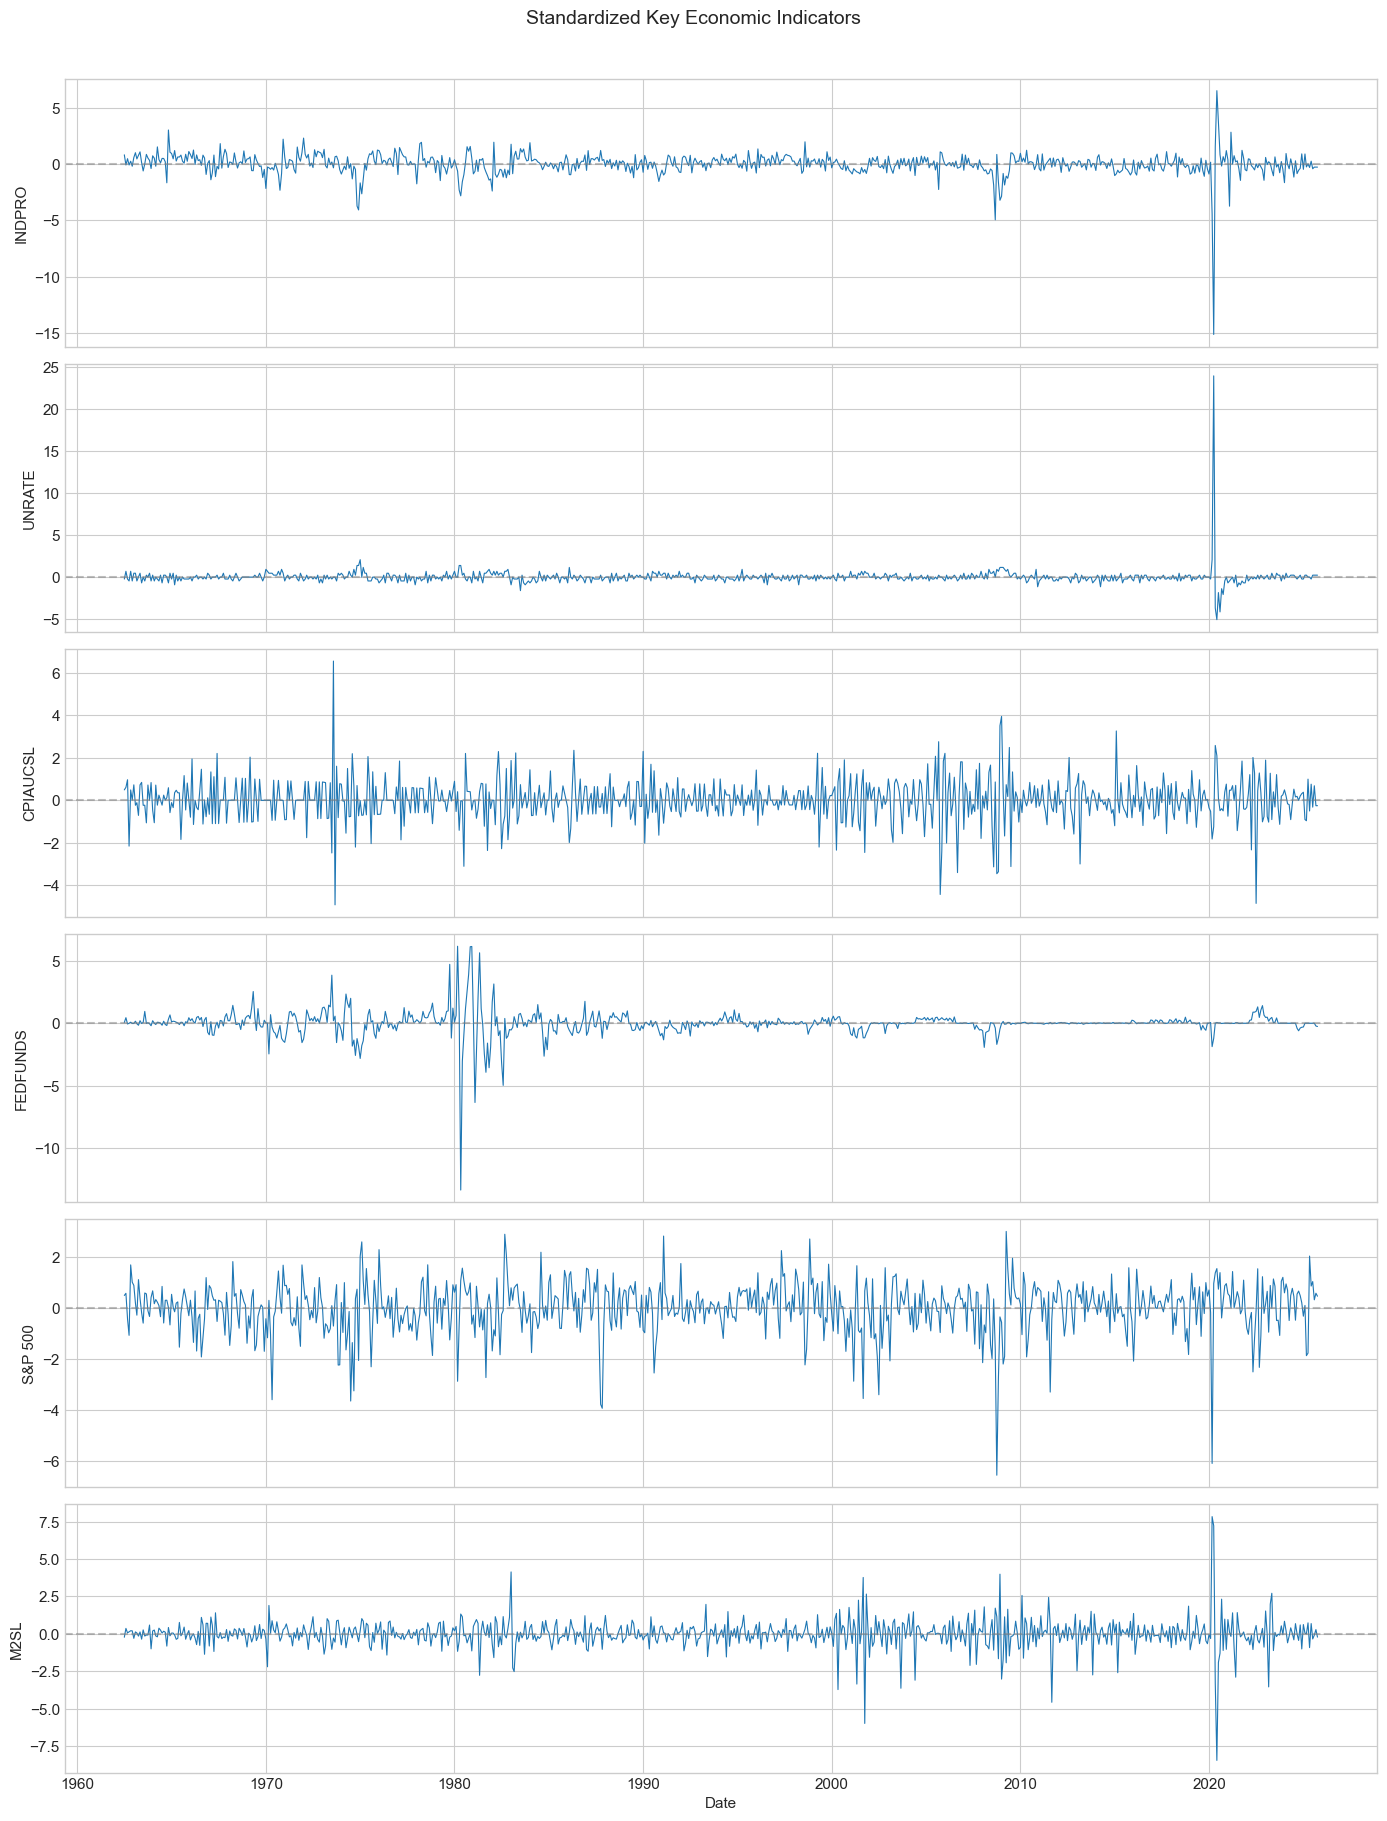

In [40]:
# Plot time series of key indicators
fig, axes = plt.subplots(len(key_indicators), 1, figsize=(14, 3*len(key_indicators)), sharex=True)

for i, var in enumerate(key_indicators):
    ax = axes[i] if len(key_indicators) > 1 else axes
    ax.plot(dates, data_standardized[var], linewidth=0.8)
    ax.set_ylabel(var)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
axes[-1].set_xlabel('Date')
plt.suptitle('Standardized Key Economic Indicators', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

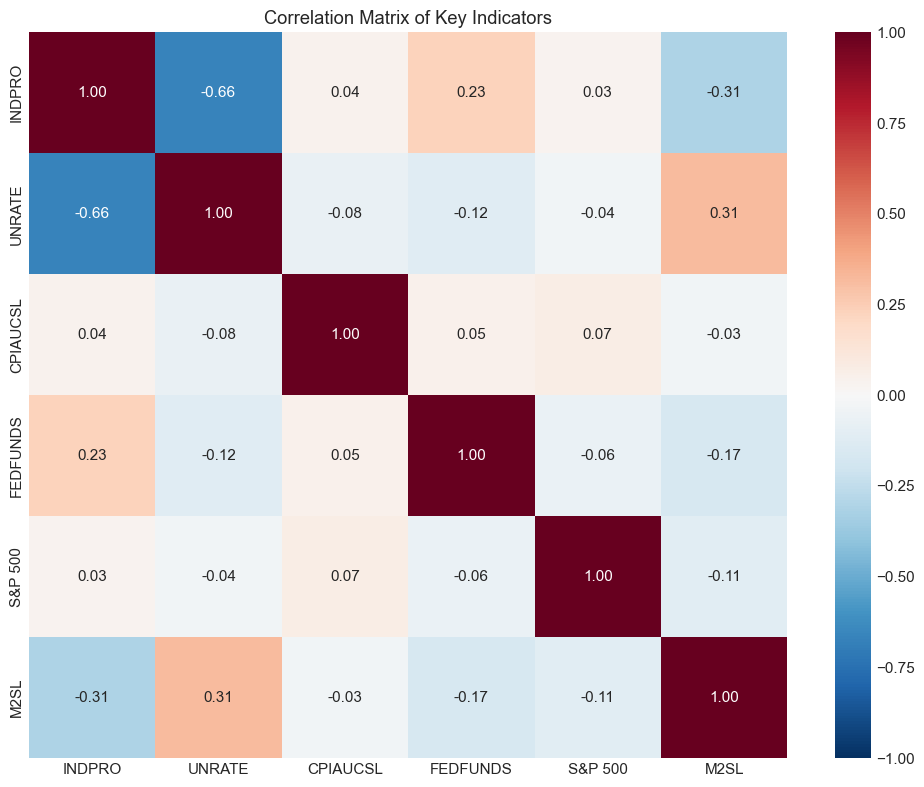

In [41]:
# Correlation matrix for key indicators
if len(key_indicators) >= 4:
    corr_matrix = data_standardized[key_indicators].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix of Key Indicators')
    plt.tight_layout()
    plt.show()

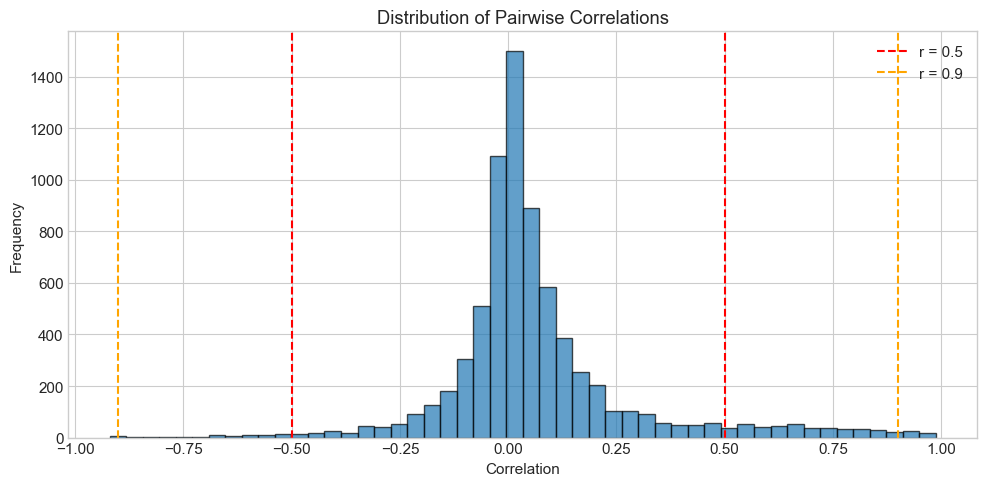


Pairs with |r| > 0.9: 51 (0.7% of all pairs)


In [42]:
# Distribution of all pairwise correlations
full_corr = data_standardized.corr()

upper_tri = full_corr.where(np.triu(np.ones(full_corr.shape), k=1).astype(bool))
all_corrs = upper_tri.stack().values

plt.figure(figsize=(10, 5))
plt.hist(all_corrs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--', label='r = 0.5')
plt.axvline(x=-0.5, color='r', linestyle='--')
plt.axvline(x=0.9, color='orange', linestyle='--', label='r = 0.9')
plt.axvline(x=-0.9, color='orange', linestyle='--')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Correlations')
plt.legend()
plt.tight_layout()
plt.show()

high_corr = np.abs(all_corrs) > 0.9
print(f"\nPairs with |r| > 0.9: {high_corr.sum()} ({100*high_corr.mean():.1f}% of all pairs)")

## 6. Principal Component Analysis

Given the high correlations, let's examine the effective dimensionality.

In [43]:
# Full PCA
pca = PCA()
pca.fit(X)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"Variance explained by first 5 PCs: {100*cumulative_var[4]:.1f}%")
print(f"Variance explained by first 10 PCs: {100*cumulative_var[9]:.1f}%")
print(f"Variance explained by first 20 PCs: {100*cumulative_var[19]:.1f}%")

Variance explained by first 5 PCs: 44.7%
Variance explained by first 10 PCs: 57.1%
Variance explained by first 20 PCs: 71.9%


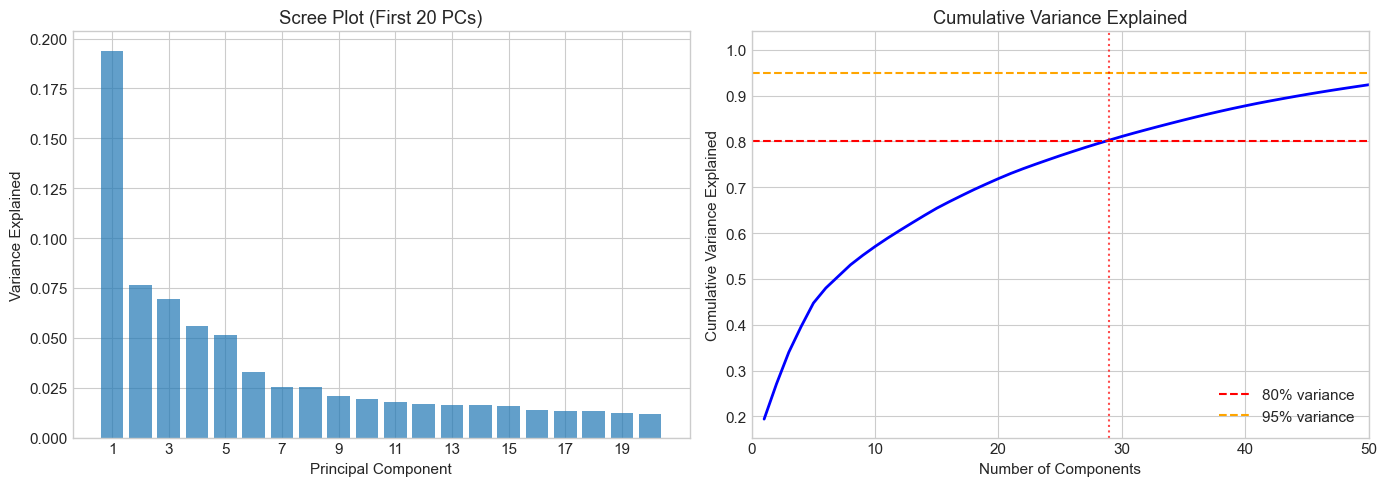


Components needed for 80% variance: 29
Components needed for 95% variance: 58


In [44]:
# Scree plot and cumulative variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax = axes[0]
ax.bar(range(1, 21), explained_var[:20], alpha=0.7)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained')
ax.set_title('Scree Plot (First 20 PCs)')
ax.set_xticks(range(1, 21, 2))

# Cumulative variance
ax = axes[1]
ax.plot(range(1, len(cumulative_var)+1), cumulative_var, 'b-', linewidth=2)
ax.axhline(y=0.8, color='r', linestyle='--', label='80% variance')
ax.axhline(y=0.95, color='orange', linestyle='--', label='95% variance')

# Find where we hit thresholds
n_80 = np.argmax(cumulative_var >= 0.8) + 1
n_95 = np.argmax(cumulative_var >= 0.95) + 1
ax.axvline(x=n_80, color='r', linestyle=':', alpha=0.7)
ax.axvline(x=n_95, color='orange', linestyle=':', alpha=0.7)

ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Variance Explained')
ax.set_title('Cumulative Variance Explained')
ax.legend()
ax.set_xlim(0, 50)

plt.tight_layout()
plt.show()

print(f"\nComponents needed for 80% variance: {n_80}")
print(f"Components needed for 95% variance: {n_95}")

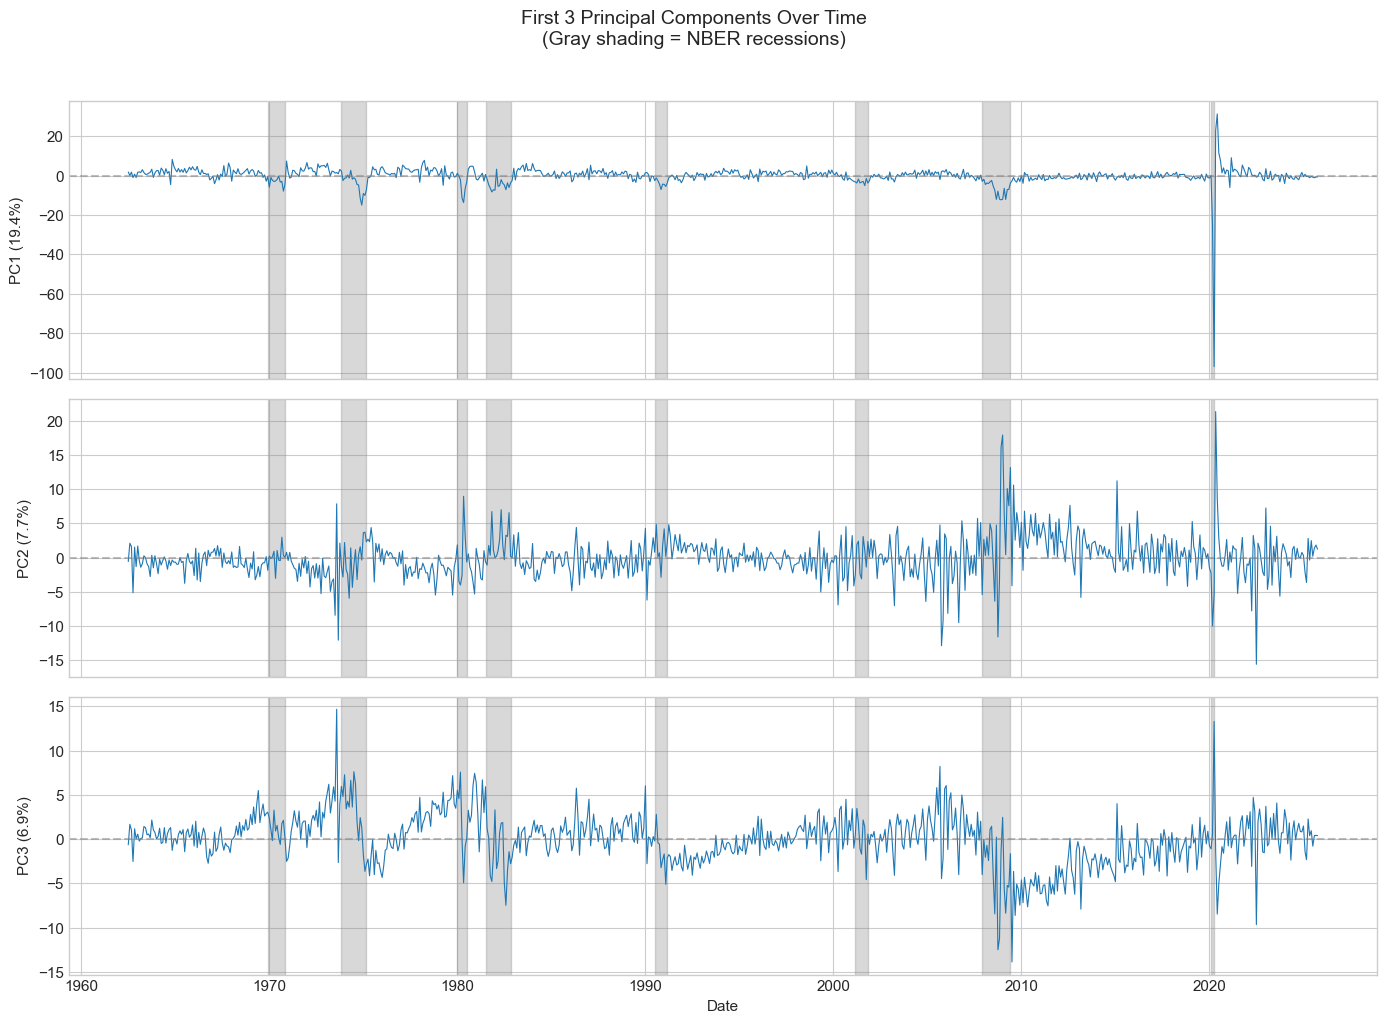

In [45]:

X_pca = pca.transform(X)[:, :3]

# NBER recession dates
recessions = [
    ('1969-12-01', '1970-11-01'),
    ('1973-11-01', '1975-03-01'),
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01'),
]

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(dates, X_pca[:, i], linewidth=0.8)
    ax.set_ylabel(f'PC{i+1} ({100*explained_var[i]:.1f}%)')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Shade recessions
    for start, end in recessions:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                   color='gray', alpha=0.3)

axes[-1].set_xlabel('Date')
plt.suptitle('First 3 Principal Components Over Time\n(Gray shading = NBER recessions)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [46]:
# What variables load heavily on PC1?
pc1_loadings = pd.Series(pca.components_[0], index=feature_names)
pc1_loadings_sorted = pc1_loadings.abs().sort_values(ascending=False)

print("Top 10 variables loading on PC1:")
for var in pc1_loadings_sorted.head(10).index:
    print(f"  {var}: {pc1_loadings[var]:.3f}")

Top 10 variables loading on PC1:
  IPMANSICS: 0.187
  PAYEMS: 0.186
  USGOOD: 0.185
  IPFPNSS: 0.183
  INDPRO: 0.183
  USTPU: 0.180
  MANEMP: 0.180
  CUMFNS: 0.179
  SRVPRD: 0.177
  IPFINAL: 0.176


## 7. Outlier Detection

Identify periods with extreme multivariate deviations using Mahalanobis distance.

In [47]:
# Use first 10 PCs for stable covariance estimation
n_pcs = 10
X_reduced = pca.transform(X)[:, :n_pcs]

# Compute Mahalanobis distance
mean_vec = X_reduced.mean(axis=0)
cov_mat = np.cov(X_reduced.T)
cov_inv = np.linalg.inv(cov_mat)

mahal_dist = np.array([mahalanobis(X_reduced[t], mean_vec, cov_inv) for t in range(T)])

print(f"Mahalanobis distance:")
print(f"  Mean: {mahal_dist.mean():.2f}")
print(f"  Std: {mahal_dist.std():.2f}")
print(f"  Max: {mahal_dist.max():.2f}")

Mahalanobis distance:
  Mean: 2.66
  Std: 1.71
  Max: 24.75


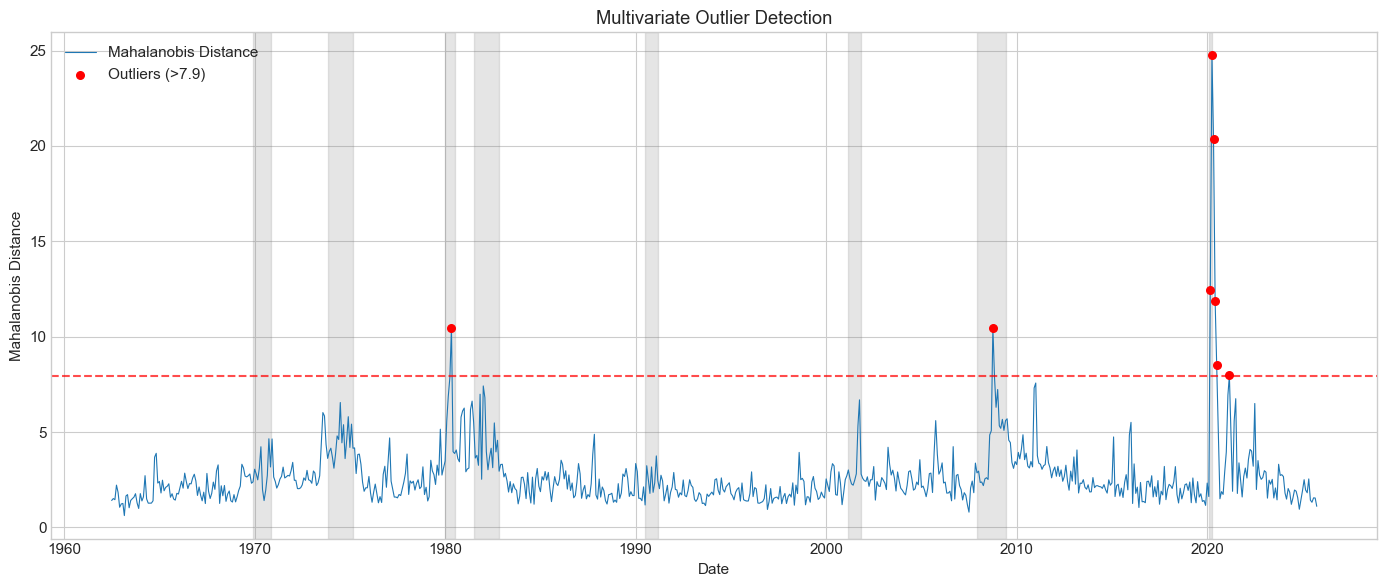


Outlier periods (8 months):
  1980-05
  2008-10
  2020-03
  2020-04
  2020-05
  2020-06
  2020-07
  2021-03


In [48]:
# Plot Mahalanobis distance over time
threshold_99 = np.percentile(mahal_dist, 99)
outliers = mahal_dist > threshold_99

plt.figure(figsize=(14, 6))
plt.plot(dates, mahal_dist, linewidth=0.8, label='Mahalanobis Distance')
plt.scatter(dates[outliers], mahal_dist[outliers], color='red', s=30, 
            label=f'Outliers (>{threshold_99:.1f})', zorder=5)
plt.axhline(y=threshold_99, color='r', linestyle='--', alpha=0.7)

# Shade recessions
for start, end in recessions:
    plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
               color='gray', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Mahalanobis Distance')
plt.title('Multivariate Outlier Detection')
plt.legend()
plt.tight_layout()
plt.show()

# List outlier dates
outlier_dates = dates[outliers]
print(f"\nOutlier periods ({len(outlier_dates)} months):")
for d in outlier_dates:
    print(f"  {d.strftime('%Y-%m')}")

In [49]:
max_idx = np.argmax(mahal_dist)
max_date = dates[max_idx]

print(f"Most extreme outlier: {max_date.strftime('%Y-%m')}")
print(f"Mahalanobis distance: {mahal_dist[max_idx]:.2f}")
print(f"\nStandardized values for key indicators:")
for var in key_indicators:
    val = data_standardized.loc[max_date, var]
    print(f"  {var}: {val:.2f} std from mean")

Most extreme outlier: 2020-04
Mahalanobis distance: 24.75

Standardized values for key indicators:
  INDPRO: -15.12 std from mean
  UNRATE: 23.94 std from mean
  CPIAUCSL: -1.25 std from mean
  FEDFUNDS: -1.21 std from mean
  S&P 500: 0.95 std from mean
  M2SL: 7.23 std from mean
